In [25]:
# we load the things!

from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import *
from ngsolve.fem import LeviCivitaSymbol, Einsum

import scipy.sparse as sp
from scipy.optimize import curve_fit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [26]:
# functions for differential operators on manufactured solutions 

coords = [x,y,z]

def JacobianOfCF(cf):
    """ Function to compute the Jacobi Matrix of a vector coefficient function cf """

    Jac_u_3D = CF((
    cf[0].Diff(x), cf[0].Diff(y), cf[0].Diff(z),
    cf[1].Diff(x), cf[1].Diff(y), cf[1].Diff(z),
    cf[2].Diff(x), cf[2].Diff(y), cf[2].Diff(z)
    ), dims=(3, 3))

    return Jac_u_3D

def GGrad(cf):
    """ Function to compute the gradient of a scalar Coefficient Function """
    gg = [cf.Diff(coords[i]) for i in range(mesh.dim)]
    return CF(tuple(gg))


def GCurl(cf):
    """ Function to compute the curl or rot of vec cf using Jacobian """

    if cf.dim == 1: # if the functions is getting handed a scalar field, its to calculate the curl of the rot..
        curl_rot_u = CF((cf.Diff(y), - cf.Diff(x)))
        return curl_rot_u

    elif mesh.dim == 2:
        rot_u = CF(cf[1].Diff(x) - cf[0].Diff(y))
        return rot_u
    
    elif mesh.dim == 3:
        Jac_u = JacobianOfCF(cf)
        curl_u = CF((Jac_u[2,1] - Jac_u[1,2],  
                    Jac_u[0,2] - Jac_u[2,0],  
                    Jac_u[1,0] - Jac_u[0,1]))
        return curl_u
    

def GDiv(cf):
    """ Function to compute the divergence of a vector coefficient function """

    gd = [cf[i].Diff(coords[i]) for i in range(cf.dim)]
    return CF(sum(gd))

In [27]:
# Functions for plotting

def logspace_custom_decades(start, stop, points_per_decade):
    
    result = []
    current_decade = start
    while current_decade < stop:
        decade_points = np.logspace(np.log10(current_decade), np.log10(current_decade * 10), points_per_decade, endpoint=False)
        result.extend(decade_points)
        current_decade *= 10
    return np.array(result)

def reference_line_func(h_values, scaling_factor, slope):
    """
    Reference line model: scaling_factor * h_values ** slope.
    """
    return scaling_factor * h_values ** slope

def fit_reference_line(h_values, error_values):
    """
    Fit a reference line to the error values by finding the optimal scaling factor and slope
    using least-squares regression.
    """
    popt, _ = curve_fit(reference_line_func, h_values, error_values, p0=[1, 1])

    scaling_factor, slope = popt
    return scaling_factor, slope

In [28]:
# Functions to calculate h_max

def edge_length(v1, v2, dim):
    return np.sqrt(sum((v1[i] - v2[i])**2 for i in range(dim)))

def squared_distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.sum((v1 - v2) ** 2)

def cayley_menger_matrix(vertices):
    if len(vertices) != 4:
        raise ValueError("This method is for a tetrahedron, which requires exactly 4 vertices.")

    # Create the Cayley-Menger matrix (5x5)
    C = np.ones((5, 5))
    for i in range(5):
        C[i, i] = 0 

    for i in range(1, 5):
        for j in range(i+1, 5):
            C[i, j] = C[j, i] = squared_distance(vertices[i-1], vertices[j-1])

    return C

def triangle_area(a, b, c):
    s = (a + b + c) / 2  
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

def circumradius_2D(a, b, c):
    area = triangle_area(a, b, c)
    return a * b * c / (4 * area)

def circumradius_3D(vertices):
    C = cayley_menger_matrix(vertices)

    try:
        C_inv = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        raise ValueError("Cayley-Menger matrix is singular or not invertible.")

    M = -2 * C_inv
    circumradius = 0.5 * np.sqrt(M[0, 0])

    return circumradius

def calc_hmax(mesh):
    max_h = 0 
    if mesh.dim == 2:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            a = edge_length(vertices[0], vertices[1], 2)
            b = edge_length(vertices[1], vertices[2], 2)
            c = edge_length(vertices[2], vertices[0], 2)
            circumradius = circumradius_2D(a, b, c)
            max_h = max(max_h, circumradius)
    
    elif mesh.dim == 3:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            circumradius = circumradius_3D(vertices)
            max_h = max(max_h, circumradius)
    
    return max_h

In [29]:
# Hodge Laplace for 1-forms function

def hodgeLaplace1Forms(mesh, 
                       omega_m, 
                       order = 1, 
                       C_w = 1 ):
    
    h_curl = HCurl(mesh, order=order, type1=False)  # For 1-forms, H(curl)
    h_1 = H1(mesh, order=order+1)     # For 0-forms, H1 space
    fes = h_curl * h_1
    (omega, sigma), (eta, tau) = fes.TnT()

    a = BilinearForm(fes)

    a += sigma * tau * dx
    a += - omega * grad(tau) * dx

    a +=  grad(sigma) * eta * dx
    a +=  curl(omega) * curl(eta) * dx

    n = specialcf.normal(mesh.dim)
    
    h = specialcf.mesh_size #computed on every edge of the boundary integration is way faster than setting a constant!

    if mesh.dim == 3:
        a += curl(omega) * Cross(eta, n) * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
        a += Cross(omega, n) * curl(eta) * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
        a += (C_w / h) * Cross(omega, n) * Cross(eta, n) * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    
    else:
        tr_hs_d_omega = curl(omega)
        tr_eta = CF(eta[1]*n[0] - eta[0]*n[1])
        tr_omega = CF(omega[1]*n[0] - omega[0]*n[1])
        tr_hs_d_eta = curl(eta)

        a += tr_hs_d_omega * tr_eta * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
        a += tr_omega * tr_hs_d_eta * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
        a += (C_w / h) * tr_omega * tr_eta * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    
    # Hodge Laplcae of Omega Manufactured
    hL_omega_m = CF(GCurl(GCurl(omega_m)) - GGrad(GDiv(omega_m))) 

    f_rhs = LinearForm(fes)
    f_rhs += hL_omega_m * eta * dx

    a.Assemble()
    f_rhs.Assemble()

    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    #cond_nr = np.linalg.cond(A.todense()) # takes way longer than solving the system lolll..

    sol = GridFunction(fes)
    res = f_rhs.vec-a.mat * sol.vec
    inv = a.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    sol.vec.data += inv * res

    gf_omega , gf_sigma = sol.components

    curl_omega = curl(gf_omega)
    grad_sigma = grad(gf_sigma)

    curl_omega_m = CF(GCurl(omega_m))
    sigma_m = - CF(GDiv(omega_m))
    grad_sigma_m = CF(GGrad(sigma_m))

    L2_error_omega = sqrt(Integrate((gf_omega - omega_m)**2, mesh))
    L2_error_curl_omega = sqrt(Integrate((curl_omega - curl_omega_m)**2, mesh))
    L2_error_sigma = sqrt(Integrate((gf_sigma - sigma_m)**2, mesh))
    L2_error_grad_sigma = sqrt(Integrate((grad_sigma - grad_sigma_m)**2, mesh))

    return fes.ndof, Norm(res), L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma

In [30]:
# definition of manufactured solutions

A = 0.05  # Pulse Amplitude
sigma_pulse = 0.05  # Pulse Width
r0 = (0.5, 0.5)  # Pulse Center
n_pulse = (1, 0)  # Pulse Direction

omega_m_gauss_2D = CF((
    A * exp(-((x - r0[0])**2 + (y - r0[1])**2) / (2 * sigma_pulse**2)) * n_pulse[0],
    A * exp(-((x - r0[0])**2 + (y - r0[1])**2) / (2 * sigma_pulse**2)) * n_pulse[1]
))

omega_m_sinusoids_2D = CF((sin(pi*x)*sin(pi*y), sin(pi*x)*sin(pi*y)))

A_pulse_3D = 0.05
sigma_pulse_3D = 0.2
r0_pulse_3D = (0.5, 0.5, 0.5)
n_pulse_3D = (1, 0, 0)

omega_m_gauss_pulse_3D = CF((
    A_pulse_3D * exp(-((x - r0_pulse_3D[0])**2 + (y - r0_pulse_3D[1])**2 + (z - r0_pulse_3D[2])**2) / (2 * sigma_pulse_3D**2)) * n_pulse_3D[0],
    A_pulse_3D * exp(-((x - r0_pulse_3D[0])**2 + (y - r0_pulse_3D[1])**2 + (z - r0_pulse_3D[2])**2) / (2 * sigma_pulse_3D**2)) * n_pulse_3D[1],
    A_pulse_3D * exp(-((x - r0_pulse_3D[0])**2 + (y - r0_pulse_3D[1])**2 + (z - r0_pulse_3D[2])**2) / (2 * sigma_pulse_3D**2)) * n_pulse_3D[2]
))

omega_m_sinusoids_3D = CF((sin(pi*x)*sin(pi*y)*sin(pi*z), 
              sin(pi*x)*sin(pi*y)*sin(pi*z), 
              sin(pi*x)*sin(pi*y)*sin(pi*z)))



In [31]:
# Convergence study data generation for 2D

refinement_steps = 4
maxh_values = [] 
Cw_vals = logspace_custom_decades(10**-1, 10**10, 3)
mesh = Mesh(unit_square.GenerateMesh(maxh=0.25)) # starting mesh!

h_max_eval = calc_hmax(mesh)
maxh_values.append(h_max_eval)

orders = [1, 2, 3, 4]
results_cw_2D = []

for refinement_step in range(refinement_steps): 
    #print(f"hmax after refinement {refinement_step}: {h_max_eval}")

    for order_cw in orders:
        results_cw = []

        for C_w in Cw_vals:
            omega_m = omega_m_sinusoids_2D

            ndof, res, L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma = hodgeLaplace1Forms(
                mesh, omega_m, order=order_cw, C_w=C_w
            )

            results_cw.append({
                'order': order_cw,
                'hmax': h_max_eval,
                'C_w': C_w,
                'ndof': ndof,
                'res': res,
                'L2_error_omega': L2_error_omega,
                'L2_error_curl_omega': L2_error_curl_omega,
                'L2_error_sigma': L2_error_sigma,
                'L2_error_grad_sigma': L2_error_grad_sigma
            })

        df_cw = pd.DataFrame(results_cw)
        results_cw_2D.append(df_cw)

    if refinement_step < refinement_steps - 1:  # Refinement for the next step
        mesh.Refine() 
        h_max_eval = calc_hmax(mesh)
        maxh_values.append(h_max_eval) 

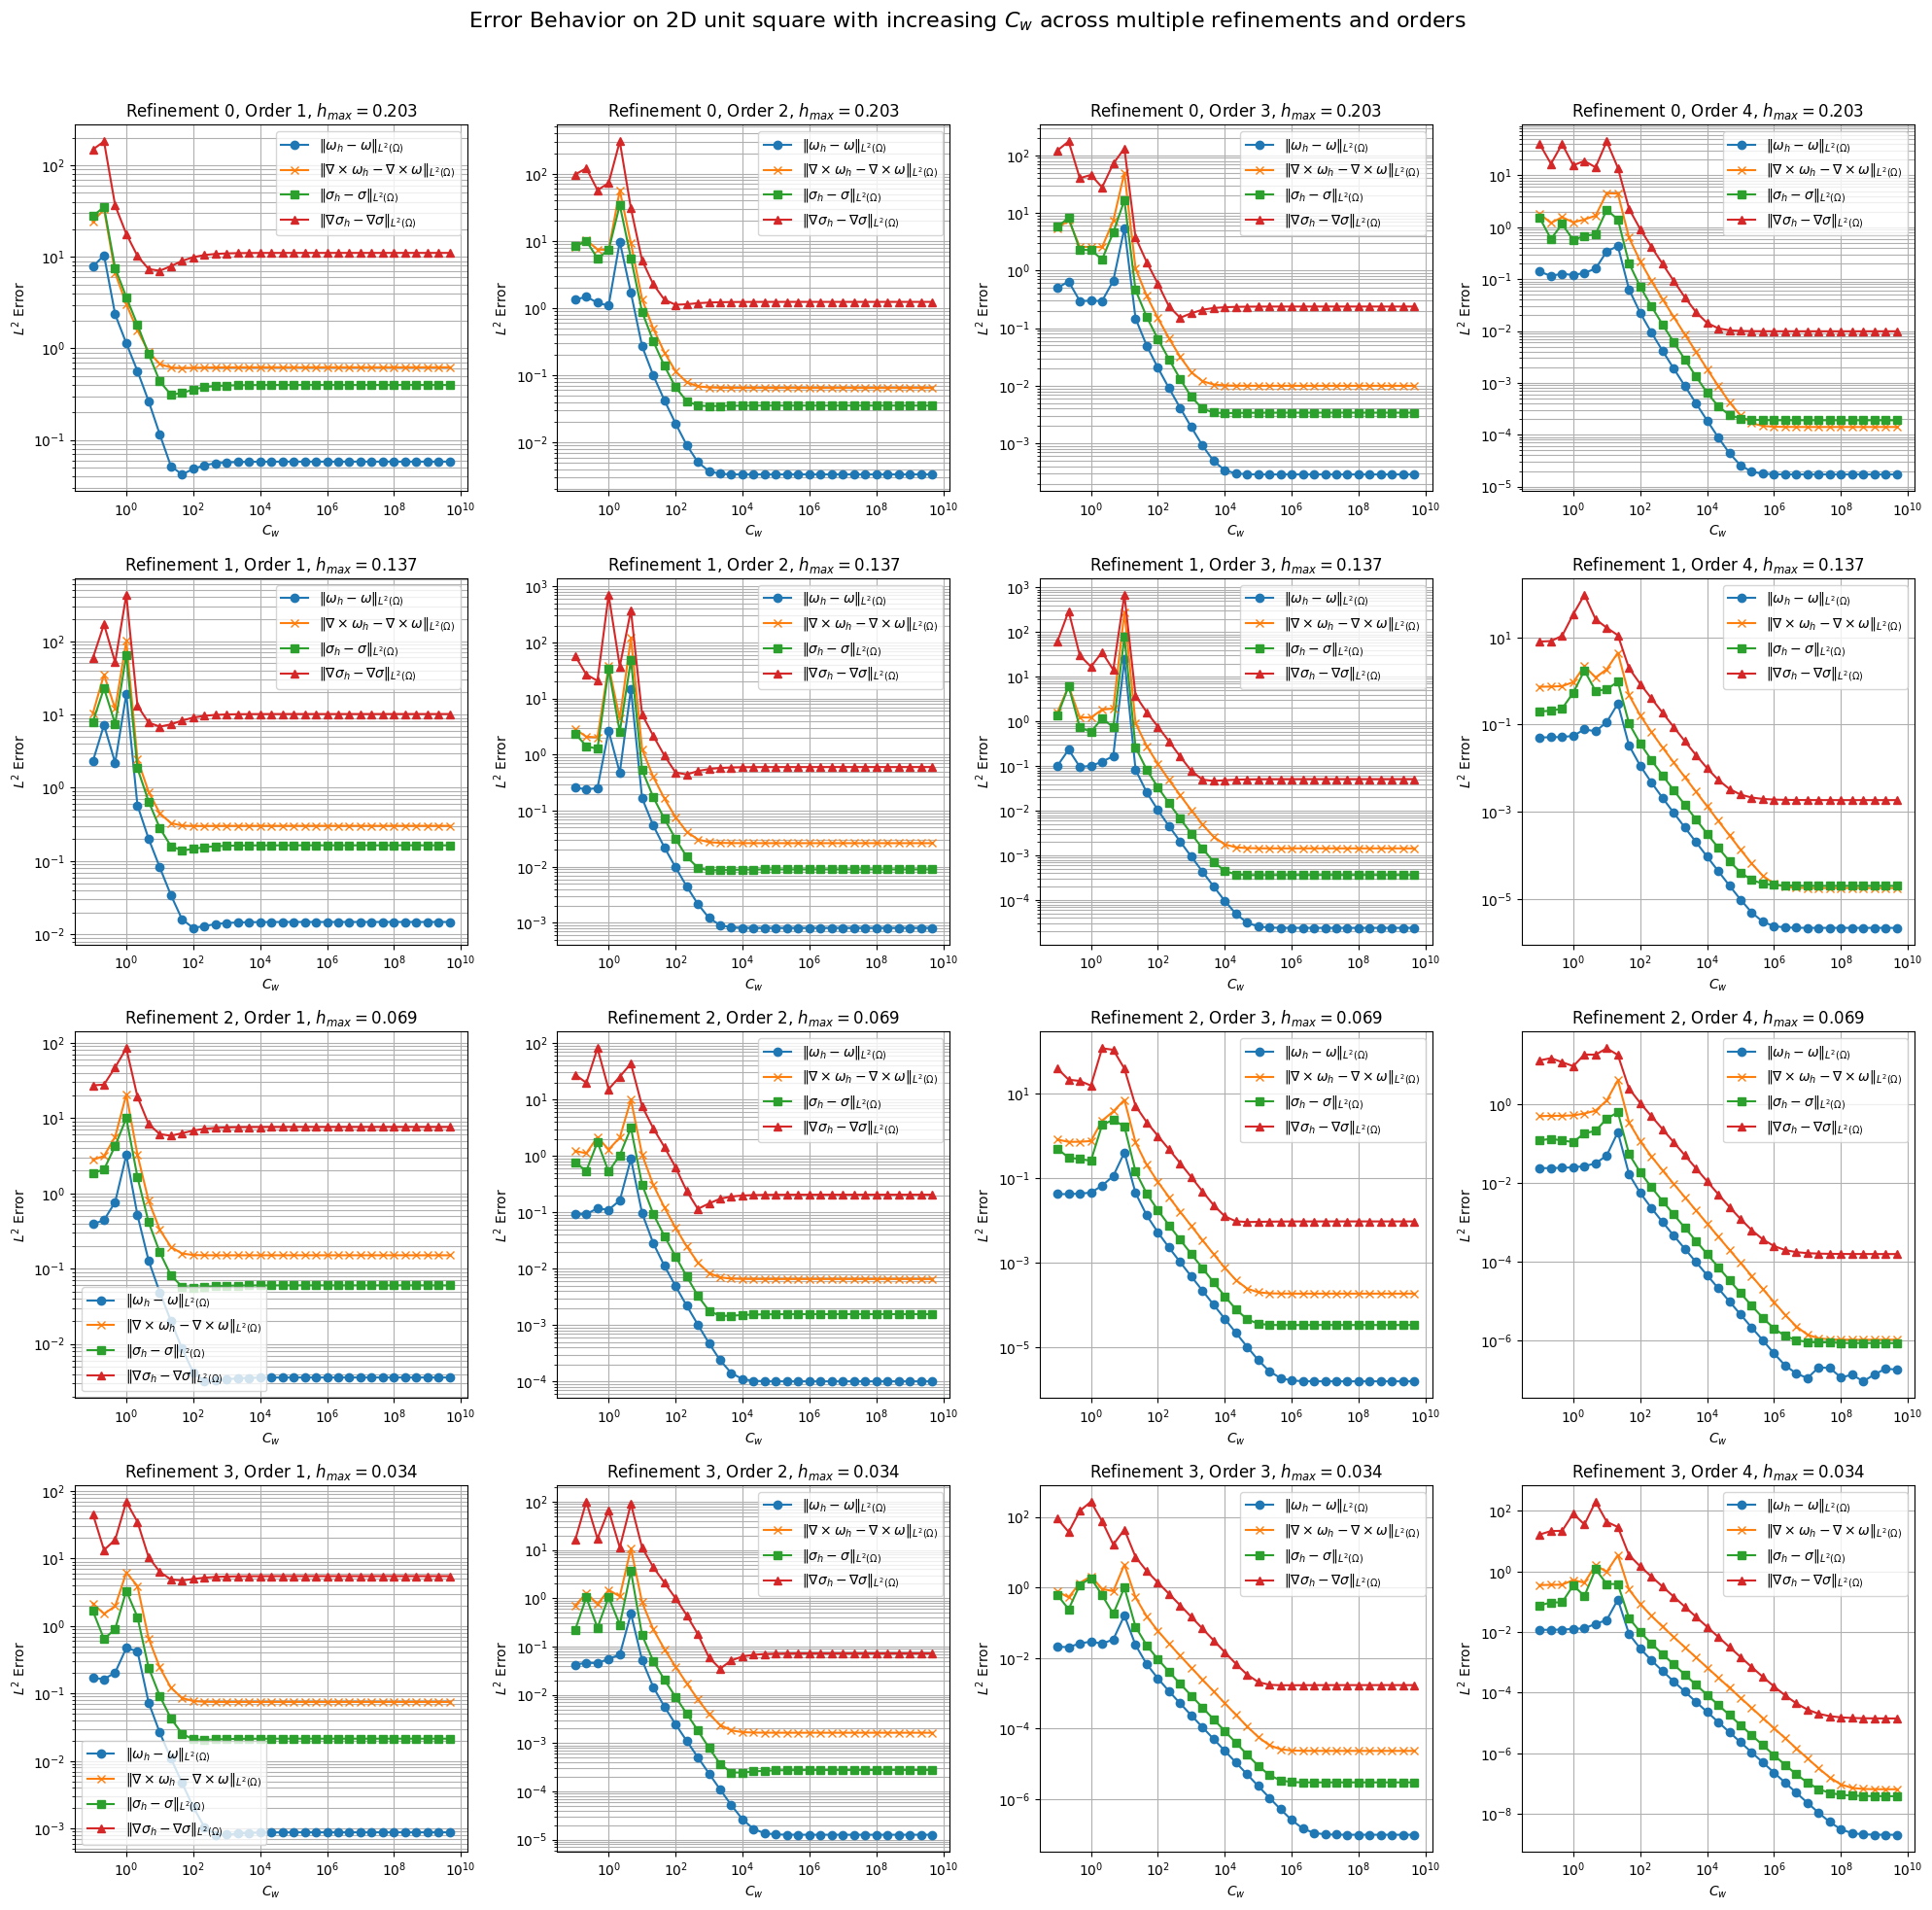

In [57]:
# plot c_W behavior
# here we identify the best C_w values for all combinations of "order" and "h_max"
saveFigure1 = False
num_refinements = refinement_steps
num_orders = len(orders)

fig, axs = plt.subplots(num_refinements, num_orders, figsize=(20, 5 * num_refinements))
fig.suptitle("Error Behavior on 2D unit square with increasing $C_w$ across multiple refinements and orders", fontsize=16)

for refinement_step in range(num_refinements):
    for i, order in enumerate(orders):
        ax = axs[refinement_step, i]
        df = results_cw_2D[refinement_step * num_orders + i]
        
        hmax_value = round(maxh_values[refinement_step], 3)

        line_omega, = ax.plot(df['C_w'], df['L2_error_omega'], label=r'$\Vert \omega_h - \omega \Vert_{L^2(\Omega)}$', marker='o')
        line_curl_omega, = ax.plot(df['C_w'], df['L2_error_curl_omega'], label=r'$\Vert \nabla \times \omega_h - \nabla \times \omega \Vert_{L^2(\Omega)}$', marker='x')
        line_sigma, = ax.plot(df['C_w'], df['L2_error_sigma'], label=r'$\Vert \sigma_h - \sigma \Vert_{L^2(\Omega)}$', marker='s')
        line_grad_sigma, = ax.plot(df['C_w'], df['L2_error_grad_sigma'], label=r'$\Vert \nabla \sigma_h - \nabla \sigma \Vert_{L^2(\Omega)}$', marker='^')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$C_w$')
        ax.set_ylabel('$L^2$ Error')
        ax.grid(True, which='both', axis='both')
        ax.set_title(f'Refinement {refinement_step}, Order {order}, $h_{{max}} = {hmax_value}$')
        ax.legend(handles=[line_omega, line_curl_omega, line_sigma, line_grad_sigma])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
if saveFigure1 == True:
    fig.savefig('/home/tellocam/CSE/master_thesis/figures/HL_1forms_2D_Cw.pdf', format='pdf', bbox_inches='tight')

#print(df_cw[['order', 'hmax', 'C_w']].head())


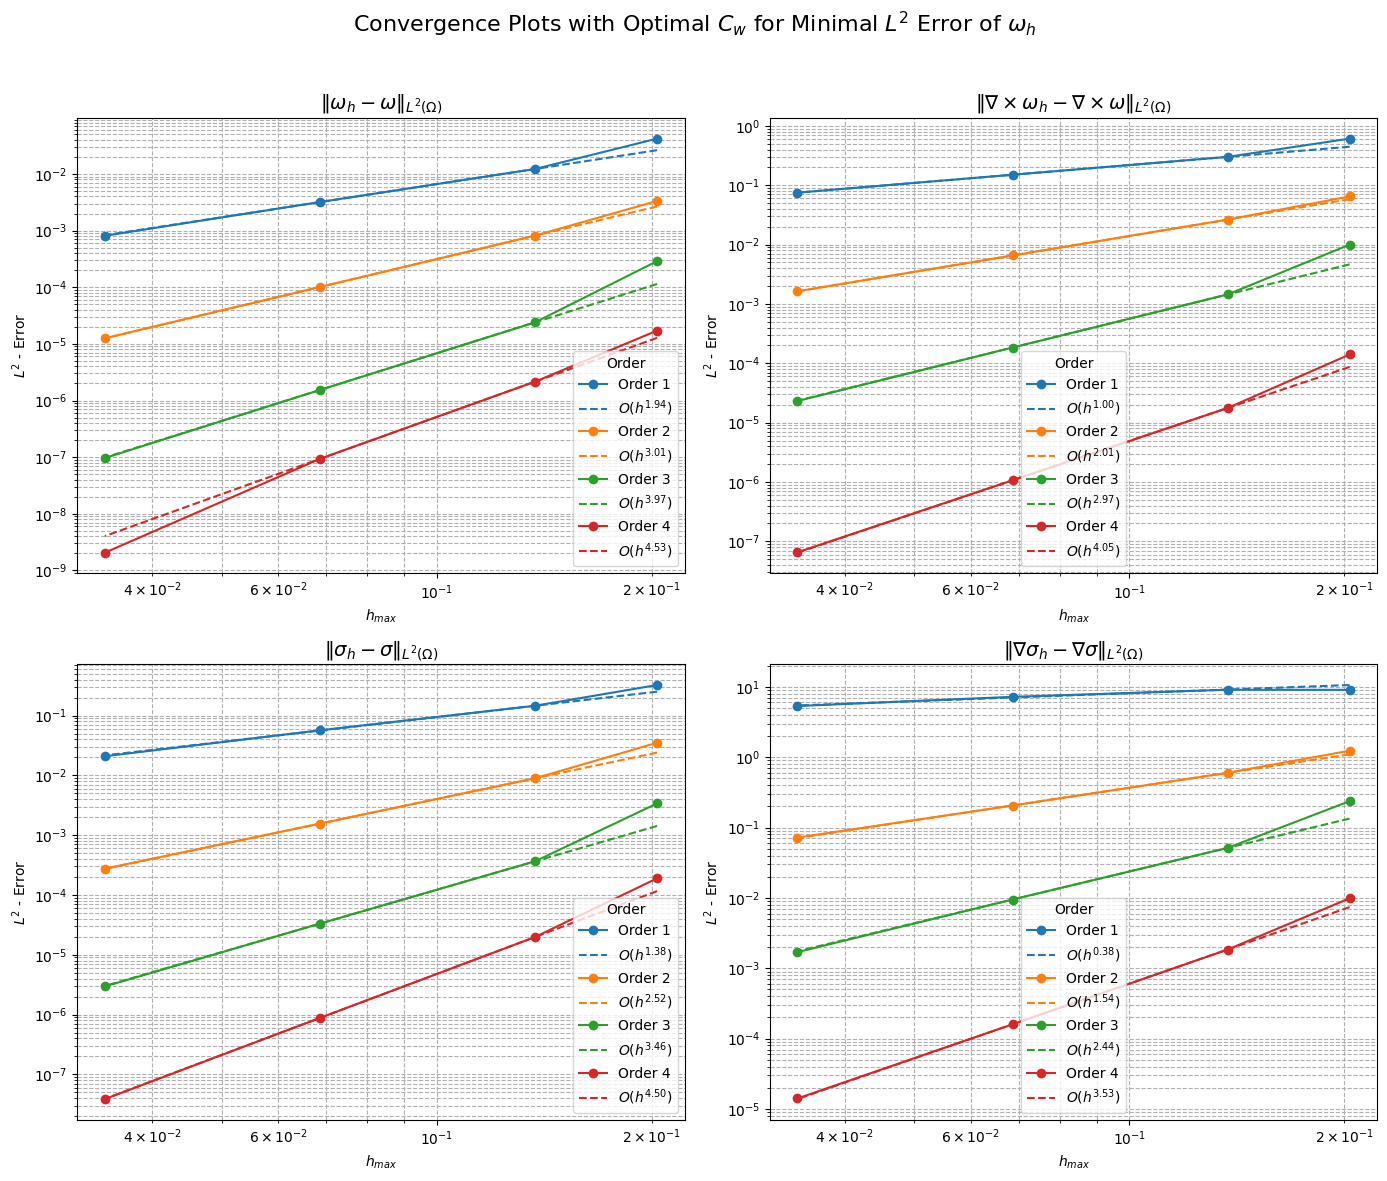

In [56]:
saveFigure2 = False
df_all_results = pd.concat(results_cw_2D, ignore_index=True)
filtered_results = []

for order_cw in orders:
    for hmax in maxh_values:
        group = df_all_results[(df_all_results['order'] == order_cw) & (df_all_results['hmax'] == hmax)]
        
        optimal_row = group.loc[group['L2_error_omega'].idxmin()]
        
        filtered_results.append(optimal_row)

df_filtered = pd.DataFrame(filtered_results)

# print(df_filtered[['order', 'hmax', 'C_w', 'L2_error_grad_sigma']])

error_columns = ['L2_error_omega', 'L2_error_curl_omega', 'L2_error_sigma', 'L2_error_grad_sigma']
error_titles = [
    r'$\Vert \omega_h - \omega \Vert_{L^2(\Omega)}$',
    r'$\Vert \nabla \times \omega_h - \nabla \times \omega \Vert_{L^2(\Omega)}$',
    r'$\Vert \sigma_h - \sigma \Vert_{L^2(\Omega)}$',
    r'$\Vert \nabla \sigma_h - \nabla \sigma \Vert_{L^2(\Omega)}$'
]

fig, axs = plt.subplots(2, 2, figsize=(14, 12))  
fig.suptitle('Convergence Plots with Optimal $C_w$ for Minimal $L^2$ Error of $\omega_h$', fontsize=16)

for i, (error_col, title) in enumerate(zip(error_columns, error_titles)):
    ax = axs[i // 2, i % 2] 

    for order_cw in orders:
        order_group = df_filtered[df_filtered['order'] == order_cw]
        
        h_values = order_group['hmax'].values
        error_values = order_group[error_col].values

        error_line, = ax.plot(h_values, error_values, label=f'Order {int(order_cw)}', marker='o')
        line_color = error_line.get_color()

        if len(h_values) >= 3:
            h_last_three = h_values[-3:]
            error_last_three = error_values[-3:]
            scaling_factor, slope = fit_reference_line(h_last_three, error_last_three)
            reference_values = scaling_factor * h_values ** slope

            ax.plot(h_values, reference_values, linestyle='--', color=line_color, label=f'$O(h^{{{slope:.2f}}})$')

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'$h_{max}$')
    ax.set_ylabel(r'$L^2$ - Error')
    ax.set_title(title, fontsize=14)

    ax.grid(True, which='both', linestyle='--')
    ax.legend(title="Order")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
if saveFigure2 == True:
    fig.savefig('/home/tellocam/CSE/master_thesis/figures/HL_1forms_2D_hConvergence.pdf', format='pdf', bbox_inches='tight')

In [45]:
# Convergence study data generation for 3D

refinement_steps_3D = 4
maxh_values_3D = [] 
Cw_vals_3D = logspace_custom_decades(1, 50, 10)

# geo = CSGeometry()
# box = OrthoBrick(Pnt(0, 0, 0), Pnt(1, 1, 1))
# geo.Add(box)

mesh = Mesh(unit_cube.GenerateMesh(maxh=1))

h_max_eval = calc_hmax(mesh)
maxh_values_3D.append(h_max_eval)

orders_3D = [1, 2, 3]
results_cw_3D = []

for refinement_step in range(refinement_steps_3D): 

    for order_cw in orders_3D:
        results_cw = []
        print("starting with order ", order_cw)
        for C_w in Cw_vals_3D:
            omega_m = omega_m_sinusoids_3D

            ndof, res, L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma = hodgeLaplace1Forms(
                mesh, omega_m, order=order_cw, C_w=C_w
            )

            results_cw.append({
                'order': order_cw,
                'hmax': h_max_eval,
                'C_w': C_w,
                'ndof': ndof,
                'res': res,
                'L2_error_omega': L2_error_omega,
                'L2_error_curl_omega': L2_error_curl_omega,
                'L2_error_sigma': L2_error_sigma,
                'L2_error_grad_sigma': L2_error_grad_sigma
            })

        df_cw = pd.DataFrame(results_cw)
        results_cw_3D.append(df_cw)

    if refinement_step < refinement_steps_3D - 1:
        mesh.Refine()
        h_max_eval = calc_hmax(mesh)
        maxh_values_3D.append(h_max_eval) 

starting with order  1
starting with order  2
starting with order  3
starting with order  1
starting with order  2
starting with order  3
starting with order  1
starting with order  2
starting with order  3
starting with order  1
starting with order  2
starting with order  3


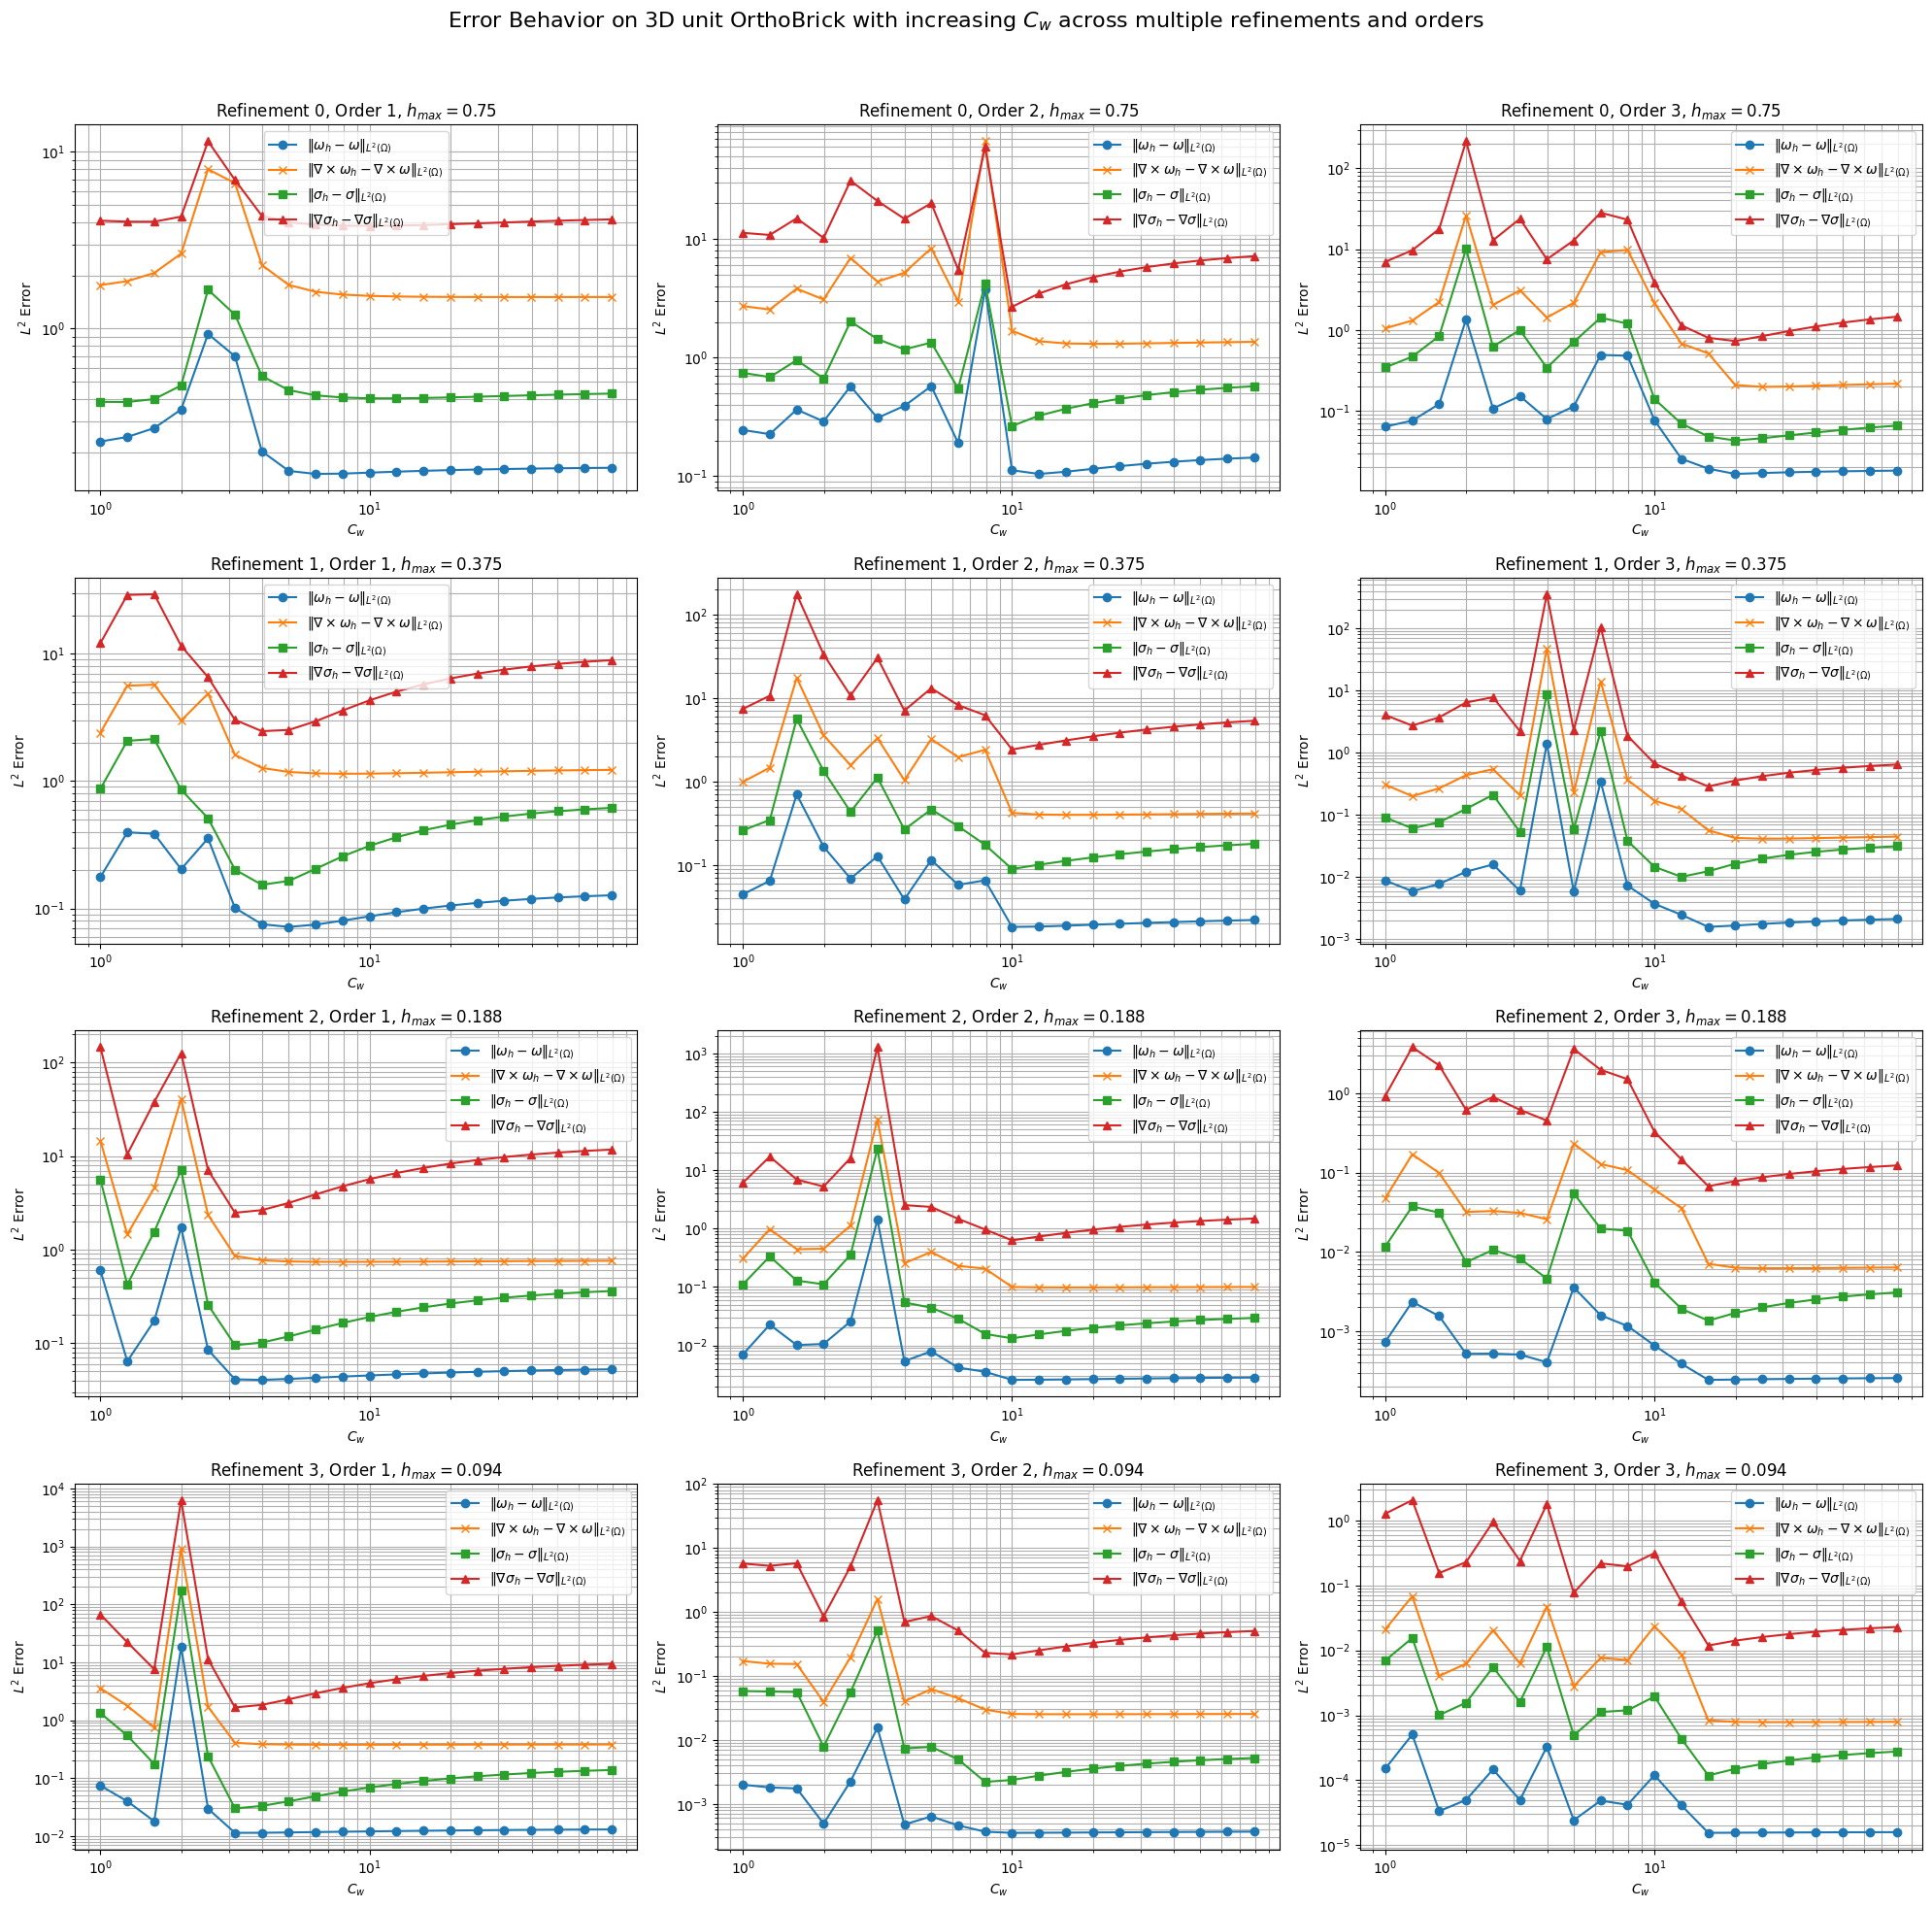

In [55]:
saveFigure3 = False
num_orders = len(orders_3D)

fig, axs = plt.subplots(refinement_steps_3D, num_orders, figsize=(20, 5 * refinement_steps_3D))
fig.suptitle("Error Behavior on 3D unit OrthoBrick with increasing $C_w$ across multiple refinements and orders", fontsize=16)

for refinement_step in range(refinement_steps_3D):
    for i, order in enumerate(orders_3D):
        ax = axs[refinement_step, i]
        df = results_cw_3D[refinement_step * num_orders + i]
        
        hmax_value = round(maxh_values_3D[refinement_step], 3)

        line_omega, = ax.plot(df['C_w'], df['L2_error_omega'], label=r'$\Vert \omega_h - \omega \Vert_{L^2(\Omega)}$', marker='o')
        line_curl_omega, = ax.plot(df['C_w'], df['L2_error_curl_omega'], label=r'$\Vert \nabla \times \omega_h - \nabla \times \omega \Vert_{L^2(\Omega)}$', marker='x')
        line_sigma, = ax.plot(df['C_w'], df['L2_error_sigma'], label=r'$\Vert \sigma_h - \sigma \Vert_{L^2(\Omega)}$', marker='s')
        line_grad_sigma, = ax.plot(df['C_w'], df['L2_error_grad_sigma'], label=r'$\Vert \nabla \sigma_h - \nabla \sigma \Vert_{L^2(\Omega)}$', marker='^')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$C_w$')
        ax.set_ylabel('$L^2$ Error')
        ax.grid(True, which='both', axis='both')
        ax.set_title(f'Refinement {refinement_step}, Order {order}, $h_{{max}} = {hmax_value}$')
        ax.legend(handles=[line_omega, line_curl_omega, line_sigma, line_grad_sigma])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
if saveFigure3 == True:
    fig.savefig('/home/tellocam/CSE/master_thesis/figures/HL_1forms_3D_Cw.pdf', format='pdf', bbox_inches='tight')

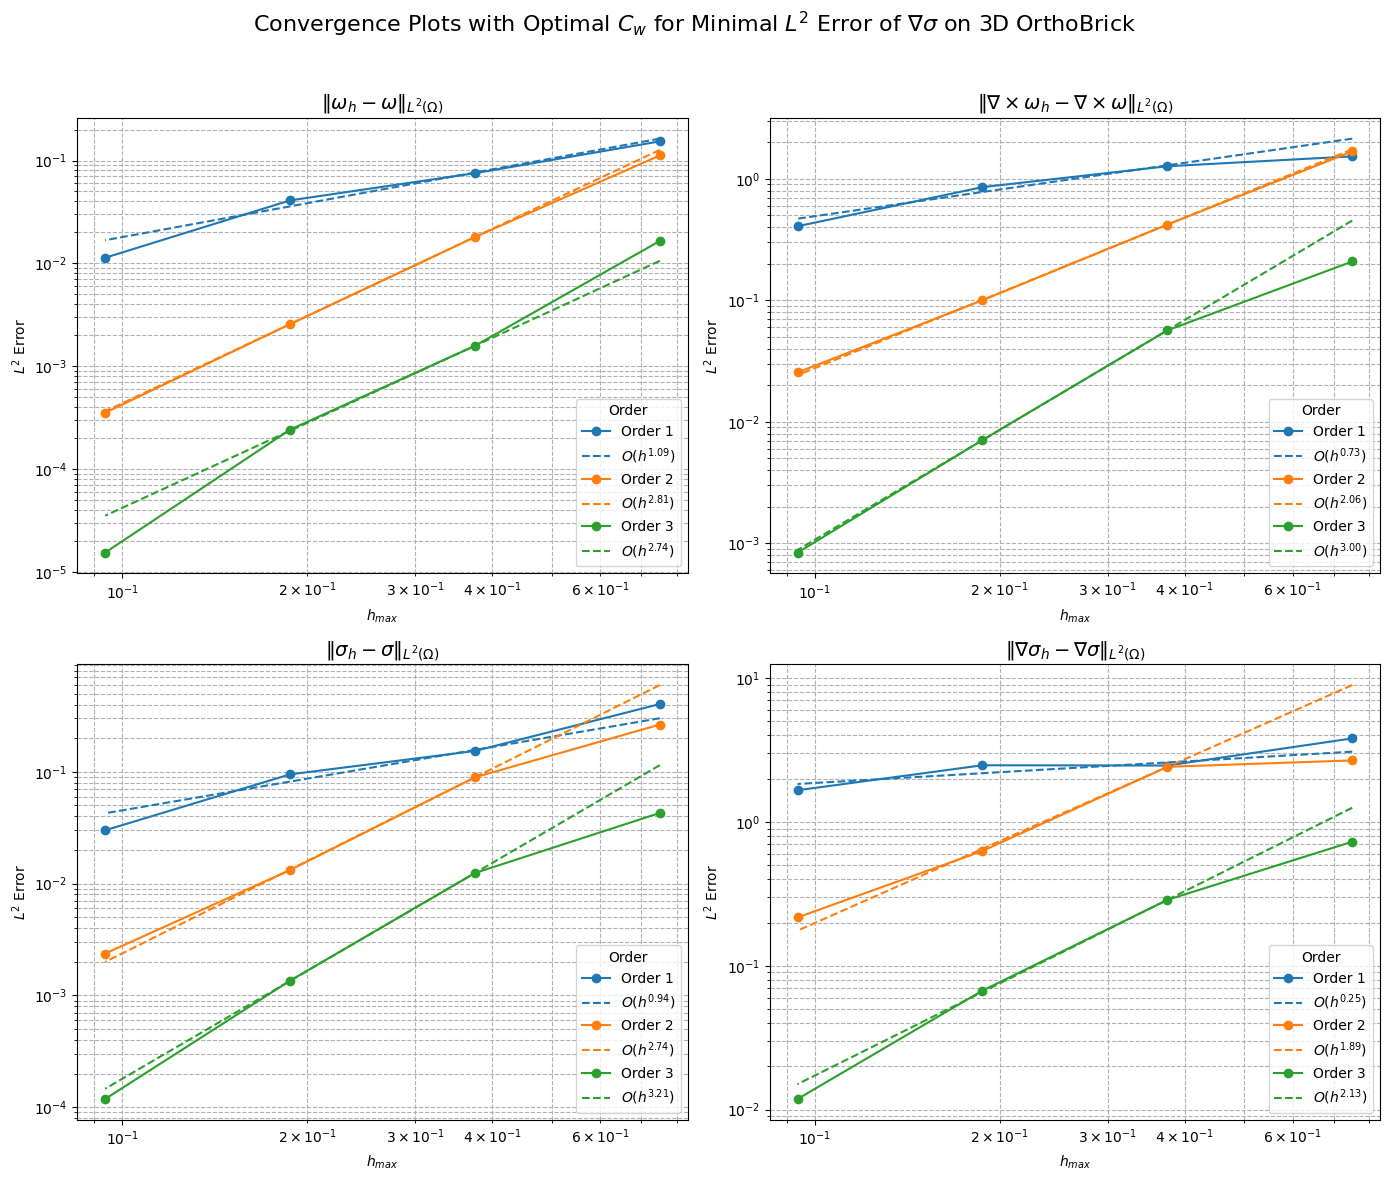

In [53]:
saveFigure4 = False
df_all_results_3D = pd.concat(results_cw_3D, ignore_index=True)
filtered_results_3D = []

for order_cw in orders_3D:
    for hmax in maxh_values_3D:
        group_3D = df_all_results_3D[(df_all_results_3D['order'] == order_cw) & (df_all_results_3D['hmax'] == hmax)]
        
        optimal_row_3D = group_3D.loc[group_3D['L2_error_grad_sigma'].idxmin()]
        
        filtered_results_3D.append(optimal_row_3D)

df_filtered_3D = pd.DataFrame(filtered_results_3D)

error_columns_3D = ['L2_error_omega', 'L2_error_curl_omega', 'L2_error_sigma', 'L2_error_grad_sigma']
error_titles_3D = [
    r'$\Vert \omega_h - \omega \Vert_{L^2(\Omega)}$',
    r'$\Vert \nabla \times \omega_h - \nabla \times \omega \Vert_{L^2(\Omega)}$',
    r'$\Vert \sigma_h - \sigma \Vert_{L^2(\Omega)}$',
    r'$\Vert \nabla \sigma_h - \nabla \sigma \Vert_{L^2(\Omega)}$'
]

fig, axs = plt.subplots(2, 2, figsize=(14, 12))  
fig.suptitle('Convergence Plots with Optimal $C_w$ for Minimal $L^2$ Error of $ \\nabla \sigma$ on 3D OrthoBrick', fontsize=16)

for i, (error_col, title) in enumerate(zip(error_columns_3D, error_titles_3D)):
    ax = axs[i // 2, i % 2] 

    for order_cw in orders_3D:
        order_group = df_filtered_3D[df_filtered_3D['order'] == order_cw]
        
        h_values = order_group['hmax'].values
        error_values = order_group[error_col].values

        error_line, = ax.plot(h_values, error_values, label=f'Order {int(order_cw)}', marker='o')
        line_color = error_line.get_color()

        if len(h_values) >= 3:
            h_last_three = h_values[-3:]
            error_last_three = error_values[-3:]
            scaling_factor, slope = fit_reference_line(h_last_three, error_last_three)
            reference_values = scaling_factor * h_values ** slope

            ax.plot(h_values, reference_values, linestyle='--', color=line_color, label=f'$O(h^{{{slope:.2f}}})$')

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'$h_{max}$')
    ax.set_ylabel(r'$L^2$ Error')
    ax.set_title(title, fontsize=14)

    ax.grid(True, which='both', linestyle='--')
    ax.legend(title="Order")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
if saveFigure4 == True:
    fig.savefig('/home/tellocam/CSE/master_thesis/figures/HL_1forms_3D_hConvergence.pdf', format='pdf', bbox_inches='tight')
